# テクニカル指標を計算してみる。

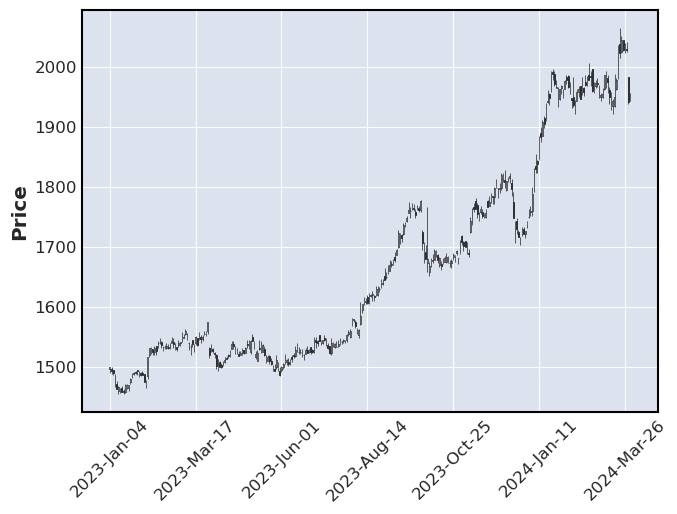

In [8]:
import sqlite3 as sql
import pandas as pd
import mplfinance as mpf

code = 9434 #ソフトバンク
con = sql.connect('/workspaces/stock/src/db.sqlite')
try:
    cur = con.cursor()
    df = pd.read_sql_query(f'SELECT date as Date, open as Open, high as High, low as Low, close as Close, volume as Volume FROM History WHERE code = {code}', con)
finally:
    con.close() 
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

mpf.plot(df, type='candle')

## 移動平均線
5日、20日、50日をそれぞれ算出してみる。


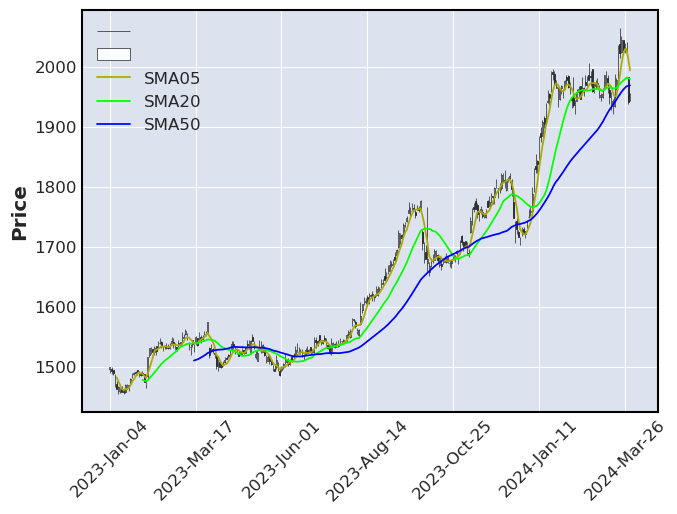

In [18]:
df['SMA05'] = df['Close'].rolling(5).mean()
df['SMA20'] = df['Close'].rolling(20).mean()
df['SMA50'] = df['Close'].rolling(50).mean()

series = [
    mpf.make_addplot(df['SMA05'], color='#AAAA00', panel=0),
    mpf.make_addplot(df['SMA20'], color='#00FF00', panel=0),
    mpf.make_addplot(df['SMA50'], color='#0000FF', panel=0)
]

fig, axes = mpf.plot(df, type='candle', addplot=series, returnfig=True)
axes[0].legend([None, None, 'SMA05', 'SMA20', 'SMA50'])
mpf.show()

一応、ta-libと比較。

In [10]:
import talib as ta

df['TA_SMA05'] = ta.SMA(df.Close, timeperiod=5)
df['TA_SMA20'] = ta.SMA(df.Close, timeperiod=20)
df['TA_SMA50'] = ta.SMA(df.Close, timeperiod=50)

df['PD_TA_05'] = df['SMA05'] - df['TA_SMA05']
df['PD_TA_20'] = df['SMA20'] - df['TA_SMA20']
df['PD_TA_50'] = df['SMA50'] - df['TA_SMA50']

print(f"05: {df.PD_TA_05.mean()}, {df.PD_TA_05.max()}, {df.PD_TA_05.min()}")
print(f"20: {df.PD_TA_20.mean()}, {df.PD_TA_20.max()}, {df.PD_TA_20.min()}")
print(f"50: {df.PD_TA_50.mean()}, {df.PD_TA_50.max()}, {df.PD_TA_50.min()}")


05: 0.0, 0.0, 0.0
20: 0.0, 0.0, 0.0
50: 0.0, 0.0, 0.0


## MACD作成


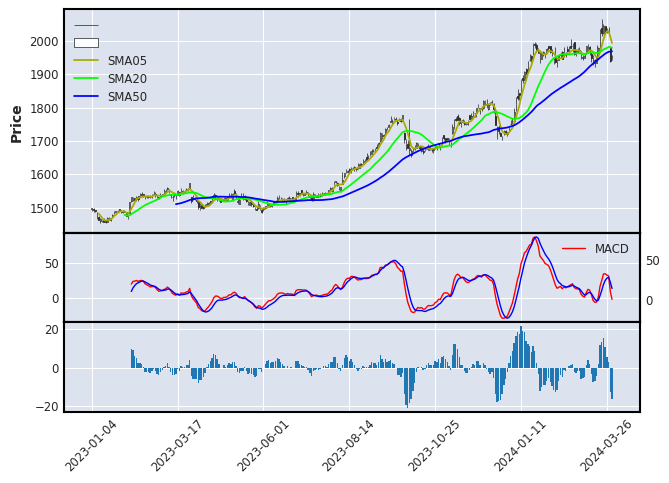

In [28]:
macd, macdsignal, macdhist = ta.MACD(df.Close, fastperiod=5, slowperiod=20, signalperiod=5)
df['MACD'] = macd
df['Signal'] = macdsignal
df['Histgram'] = macdhist

series = [
    mpf.make_addplot(df['SMA05'], color='#AAAA00', panel=0),
    mpf.make_addplot(df['SMA20'], color='#00FF00', panel=0),
    mpf.make_addplot(df['SMA50'], color='#0000FF', panel=0),
    mpf.make_addplot(df['MACD'], color='red', width=1, panel=1),
    mpf.make_addplot(df['Signal'], color='blue', width=1, panel=1),
    mpf.make_addplot(df['Histgram'], type='bar', panel=2)
]

fig, axes = mpf.plot(df, type='candle', addplot=series, returnfig=True, datetime_format='%Y-%m-%d', fontscale=0.7)
axes[0].legend([None, None, 'SMA05', 'SMA20', 'SMA50'])
axes[2].legend(['MACD', 'SIGNAL'], loc='upper left')